In [7]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing

#!pip3 install sklearn # Install machine learning library
import sklearn # For machine learning library
from sklearn.ensemble import RandomForestClassifier  # Random forest classifier
#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score

#====================================
#Read SHIPS spread-sheet data
#====================================
# Set up the location of the SHIPS data
fname='Dataset_SHIPS_RII_ATL.csv'

# Read SHIPS data
ships = pd.read_csv(fname)
ships.head()

#================================
# Set up parameters
#================================
# Year range for training and validating
year_train=['1998','2008']

# Year range for forecast
year_fcst=['2009','2017']

# Variable names for predictors
PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125

#================================
# Data pre-processing
#================================
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

# drop NaNs
ships=ships.dropna()

# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4])

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))
ships.head()

# Set the target column
ships['TAR'] = ships[TargetName].apply(lambda x: 1 if x >= RIValue else 0)


In [5]:
## Remove these variables below as they are merely identifers, they don't measure anything important

In [8]:
ships=ships.drop(['NAME', 'ID', 'DELV12', 'DELV24', 'DELV36', 'DELV48'], axis=1)

In [9]:
ships

,DATE,HOUR,VMX0,LAT,LON,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
2,980728,0,25,12.2,-29.2,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,07,1998,0
3,980728,6,25,12.6,-31.3,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,07,1998,0
4,980728,12,30,12.9,-33.3,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,07,1998,0
5,980728,18,30,13.1,-35.1,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,07,1998,0
6,980729,0,35,13.3,-36.8,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,07,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,171013,18,80,32.0,-32.5,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,10,2017,0
7393,171106,6,30,29.0,-50.7,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,11,2017,0
7394,171106,12,30,29.1,-50.4,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,11,2017,0
7395,171106,18,30,29.4,-50.2,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,11,2017,0


In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [11]:
Data = ships

In [12]:
Data

,DATE,HOUR,VMX0,LAT,LON,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
2,980728,0,25,12.2,-29.2,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,07,1998,0
3,980728,6,25,12.6,-31.3,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,07,1998,0
4,980728,12,30,12.9,-33.3,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,07,1998,0
5,980728,18,30,13.1,-35.1,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,07,1998,0
6,980729,0,35,13.3,-36.8,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,07,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,171013,18,80,32.0,-32.5,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,10,2017,0
7393,171106,6,30,29.0,-50.7,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,11,2017,0
7394,171106,12,30,29.1,-50.4,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,11,2017,0
7395,171106,18,30,29.4,-50.2,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,11,2017,0


In [45]:
## Partition the aataset into X (features only), Y (dependent variable)

In [168]:
X = Data.iloc[:,1:23]  #independent columns
Y = Data['TAR']

In [169]:
X

,HOUR,VMX0,LAT,LON,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
2,0,25,12.2,-29.2,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,07,1998,0
3,6,25,12.6,-31.3,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,07,1998,0
4,12,30,12.9,-33.3,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,07,1998,0
5,18,30,13.1,-35.1,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,07,1998,0
6,0,35,13.3,-36.8,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,07,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,18,80,32.0,-32.5,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,10,2017,0
7393,6,30,29.0,-50.7,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,11,2017,0
7394,12,30,29.1,-50.4,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,11,2017,0
7395,18,30,29.4,-50.2,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,11,2017,0


In [170]:
Y

2       0
3       0
4       0
5       0
6       0
       ..
7379    0
7393    0
7394    0
7395    0
7396    0
Name: TAR, Length: 3743, dtype: int64

In [171]:
from sklearn.ensemble import ExtraTreesClassifier 


In [172]:
X = X.drop('TAR', axis =1 )

In [233]:
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) 

[0.23707472 0.16679516 0.23018617 0.20154085 0.16440309]


In [234]:
import matplotlib.pyplot as plt

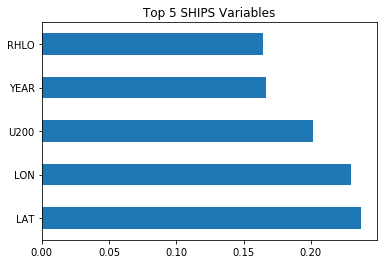

In [236]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Top 5 SHIPS Variables")
plt.show()

# Model Implementation phase using the Feature Selection method above

In [176]:
X = X[['LAT', 'YEAR', 'LON', 'U200', 'RHLO']]

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)

In [178]:
from imblearn.over_sampling import SMOTE
SM = SMOTE()

In [179]:
X_train_balanced, Y_train_balanced = SM.fit_sample(X_train, Y_train) 

In [180]:
Y_train_balanced.value_counts()

1    2296
0    2296
Name: TAR, dtype: int64

In [213]:
model = RandomForestClassifier(n_estimators=500, n_jobs=60, random_state=66, max_depth=30)

In [214]:
model.fit(X_train_balanced,Y_train_balanced)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=60, oob_score=False, random_state=66, verbose=0,
                       warm_start=False)

In [215]:
X_test

,LAT,YEAR,LON,U200,RHLO
6807,27.3,2016,-64.3,-6.9,66
2277,23.9,2003,-43.6,12.8,68
572,35.4,1999,-73.5,23.1,51
5692,23.4,2012,-62.2,13.3,61
4608,17.7,2009,-84.0,13.9,81
...,...,...,...,...,...
7244,13.1,2017,-37.0,15.8,64
3871,15.9,2007,-69.5,-6.4,76
2832,19.2,2004,-46.0,14.4,75
6294,26.5,2014,-68.3,10.0,65


In [216]:
Y_test

6807    0
2277    0
572     0
5692    0
4608    1
       ..
7244    0
3871    0
2832    0
6294    0
2056    0
Name: TAR, Length: 1236, dtype: int64

In [217]:
Y_pred = model.predict(X_test)

In [218]:
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss

In [219]:
Y_test.value_counts()

0    1120
1     116
Name: TAR, dtype: int64

In [220]:
cmatrix = confusion_matrix(Y_test, Y_pred)
cmatrix

array([[1069,   51],
       [  49,   67]], dtype=int64)

In [221]:
pss=((cmatrix[0,0] * cmatrix[1,1]) - (cmatrix[0,1] * cmatrix[1,0])) * 1.0 / ((cmatrix[1,1] + cmatrix[1,0]) * (cmatrix[0,1] + cmatrix[0,0]))
pss

0.5320504926108375

In [222]:
far=(cmatrix[0,1] * 1.0) / (cmatrix[0,1] + cmatrix[1,1])
far

0.4322033898305085

In [223]:
pod=(cmatrix[1,1] * 1.0) / (cmatrix[1,0] + cmatrix[1,1]) 
pod

0.5775862068965517

In [224]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.919093851132686

In [225]:
sklearn.metrics.f1_score(Y_test, Y_pred)

0.5726495726495726

In [226]:
from sklearn import tree

In [227]:
 clf = tree.DecisionTreeClassifier()

In [228]:
clf = clf.fit(X_train, Y_train)

In [229]:
Y_pred_clf = clf.predict(X_test)

In [230]:
cmatrix = confusion_matrix(Y_test, Y_pred)
cmatrix

array([[1069,   51],
       [  49,   67]], dtype=int64)

In [231]:
sklearn.metrics.accuracy_score(Y_test, Y_pred_clf)

0.8794498381877023

In [232]:
sklearn.metrics.f1_score(Y_test, Y_pred_clf)

0.36595744680851067